# Logistic regression Model for Heart Attack Detection

BACKGROUND:

This dataset was collected at Zheen Hospital in Erbil, Iraq, from January to May 2019. It includes medical records of patients with the aim of classifying whether an individual had a heart attack. The dataset features key health indicators, useful for diagnosis and risk assessment.

Step 1: Import data set

In [41]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy as sp
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import statsmodels.stats.proportion as ssp
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from statsmodels.tools.tools import add_constant
from sklearn import linear_model
from statsmodels.stats.outliers_influence import variance_inflation_factor
import patsy
from math import sqrt
import os
os.chdir(r"C:\Users\willi\GitHub\Heart_Attack_Risk_Assessment_PY\data\raw")

In [18]:
# Load Dataset
SADS = pd.read_csv(r"Heart_Attack_Risk_Levels_Dataset.csv")
print("✅ Dataset Loaded Successfully")
print("Data Shape:",SADS.shape)
SADS.head(5)

✅ Dataset Loaded Successfully
Data Shape: (1319, 11)


,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin,Result,Risk_Level,Recommendation
0,63,1,66,160,83,160.0,1.80,0.012,negative,Moderate,Monitor closely and consult doctor
1,20,1,94,98,46,296.0,6.75,1.060,positive,High,Immediate medical attention
2,56,1,64,160,77,270.0,1.99,0.003,negative,Moderate,Monitor closely and consult doctor
3,66,1,70,120,55,270.0,13.87,0.122,positive,High,Immediate medical attention
4,54,1,64,112,65,300.0,1.08,0.003,negative,Moderate,Monitor closely and consult doctor


In [20]:
# Print Data Types
print("Data Types in Dataset:",SADS.dtypes)

Data Types in Dataset: Age                           int64
Gender                        int64
Heart rate                    int64
Systolic blood pressure       int64
Diastolic blood pressure      int64
Blood sugar                 float64
CK-MB                       float64
Troponin                    float64
Result                       object
Risk_Level                   object
Recommendation               object
dtype: object


In [46]:
print("Data Statistical Overview:\n",SADS.describe())

Data Statistical Overview:
                Age       Gender   Heart rate  Systolic blood pressure  \
count  1319.000000  1319.000000  1319.000000              1319.000000   
mean     56.193328     0.659591    78.336619               127.170584   
std      13.638173     0.474027    51.630270                26.122720   
min      14.000000     0.000000    20.000000                42.000000   
25%      47.000000     0.000000    64.000000               110.000000   
50%      58.000000     1.000000    74.000000               124.000000   
75%      65.000000     1.000000    85.000000               143.000000   
max     103.000000     1.000000  1111.000000               223.000000   

       Diastolic blood pressure  Blood sugar        CK-MB     Troponin  
count               1319.000000  1319.000000  1319.000000  1319.000000  
mean                  72.269143   146.634344    15.274306     0.360942  
std                   14.033924    74.923045    46.327083     1.154568  
min                   

In [21]:
# Check for Missing Values
print("Missing Values in Dataset:\n",SADS.isnull().sum())

Missing Values in Dataset:
 Age                         0
Gender                      0
Heart rate                  0
Systolic blood pressure     0
Diastolic blood pressure    0
Blood sugar                 0
CK-MB                       0
Troponin                    0
Result                      0
Risk_Level                  0
Recommendation              0
dtype: int64


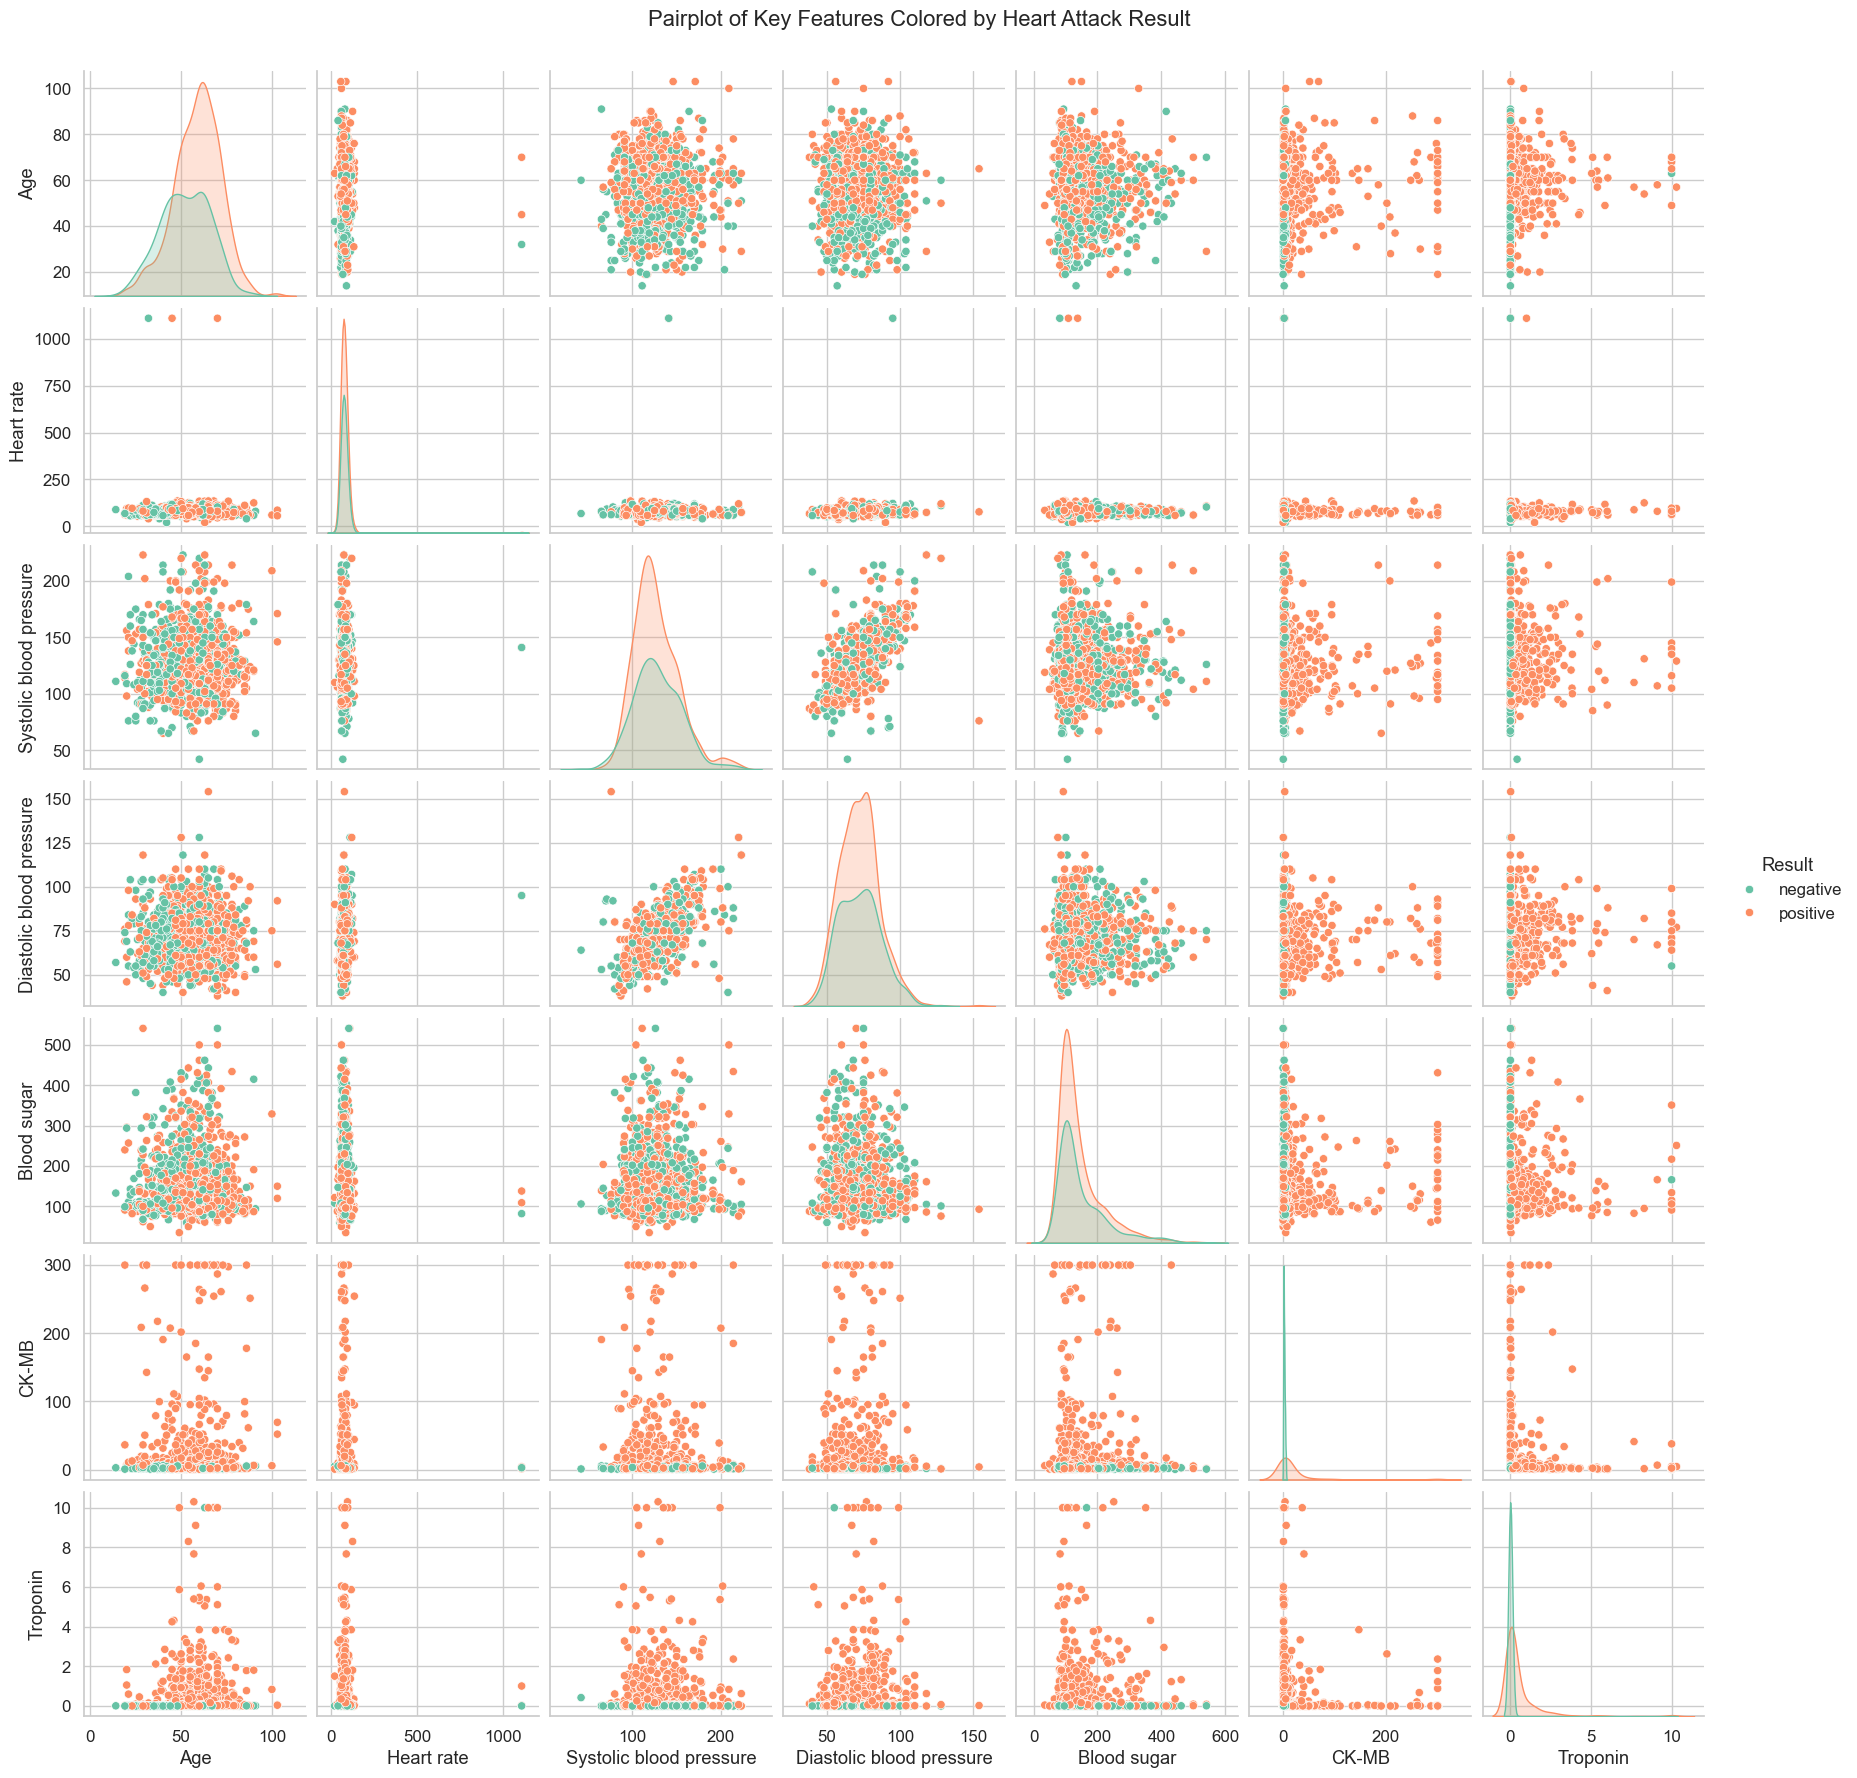

In [39]:
# Pairplot of the variables to see how they relate to each other and the target variable.

# Choose relevant numeric features
features = [
    'Age', 'Heart rate', 'Systolic blood pressure',
    'Diastolic blood pressure', 'Blood sugar', 'CK-MB', 'Troponin'
]

# Create a copy of the dataset with just selected features + target
eda_df = SADS[features + ['Result']]

# Plot
sns.pairplot(eda_df, hue='Result', palette='Set2', diag_kind='kde')
plt.suptitle("Pairplot of Key Features Colored by Heart Attack Result", y=1.02)
plt.show()

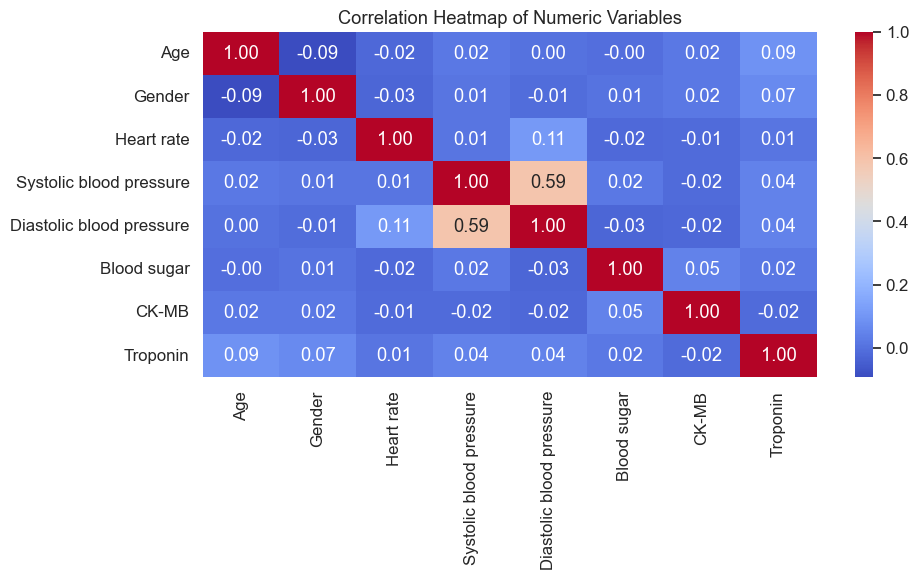

In [40]:
# Corelation Heatmap

# Compute correlation
plt.figure(figsize=(10, 6))
sns.heatmap(SADS.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Numeric Variables")
plt.tight_layout()
plt.show()

In [42]:
# Use the Variance Inflation Factor (VIF) to detect if any variables are too strongly correlated with others — which can distort your model.

# Step 1: Select numeric predictors (exclude target and non-numeric)
X = SADS[['Age', 'Gender', 'Heart rate', 'Systolic blood pressure',
        'Diastolic blood pressure', 'Blood sugar', 'CK-MB', 'Troponin']]

# Step 2: Add constant term for intercept
X_const = add_constant(X)

# Step 3: Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i)
                   for i in range(X_const.shape[1])]

vif_data

,Feature,VIF
0,const,58.429815
1,Age,1.019731
2,Gender,1.016294
3,Heart rate,1.017926
4,Systolic blood pressure,1.534659
5,Diastolic blood pressure,1.552677
6,Blood sugar,1.005429
7,CK-MB,1.003757
8,Troponin,1.016900


Based on the heatmap we can see a multicollinearity problem between Systolic vs Diastolic BP. Systolic BP is typically more predictive of cardiovascular events clinically.  As such we shall drop the Diastolic BP from the model.

In [43]:

# Where to save the processed data

os.chdir(r"C:\Users\willi\GitHub\Heart_Attack_Risk_Assessment_PY\data\processed")

In [45]:
# Generate the cleaned dataset with only the relevant features for modeling.



columns_to_keep = [
    'Age', 'Gender', 'Heart rate', 'Systolic blood pressure',
    'Blood sugar', 'CK-MB', 'Troponin', 'Result'
]

SADS_cleaned = SADS[columns_to_keep].copy()

# Step 2: Encode Result column
SADS_cleaned['Result'] = SADS_cleaned['Result'].map({'negative': 0, 'positive': 1})

# Step 3: Save to processed folder
SADS_cleaned.to_csv(r"SADS_cleaned.csv", index=False)

print("✅ Cleaned dataset saved to data/processed/heart_attack_cleaned.csv")

✅ Cleaned dataset saved to data/processed/heart_attack_cleaned.csv
